In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qMaxValueEntropy
from botorch.optim.optimize import optimize_acqf

from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement
from playground_bo.utils import pick_acqf, pick_kernel, pick_test_function, set_matplotlib_params

torch.set_default_dtype(torch.double)
set_matplotlib_params()

In [2]:
exp, ker, acqf, n_init, seed = "Zhou", "RBF", "MES", 6, 1
budget = 8
torch.manual_seed(seed)

problem = pick_test_function(exp)
bounds = torch.tensor(problem._bounds).T
dim = bounds.shape[1]
sigma = .1 # hardcoded noise level, but should be function-dependent.

data = {}
data["train_X"] = (bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n_init, dim))
train_Y = problem(data["train_X"]).view(-1, 1)
data["train_Y"] = train_Y + sigma * torch.randn(size=train_Y.shape)

### for plotting of unknown function
X = torch.linspace(float(bounds[0]), float(bounds[1]), 101).reshape(-1, 1)
Y = problem(X)

In [3]:
gpr = SingleTaskGP(data["train_X"], data["train_Y"], covar_module=pick_kernel(ker, dim))
mll = ExactMarginalLogLikelihood(gpr.likelihood, gpr)
fit_gpytorch_model(mll, max_retries=10);

In [4]:
gpr_post_mean = gpr.likelihood(gpr(X)).mean.detach().numpy()
gpr_post_var = np.sqrt(gpr.likelihood(gpr(X)).variance.detach().numpy())

In [5]:
print(gpr.covar_module.outputscale.item(), gpr.covar_module.base_kernel.lengthscale.item(), gpr.likelihood.noise.item()) # GP hyperparameters post optimization

0.4733381170548628 0.1416269908154846 0.009920765856856072


In [6]:
# bounds = problem._bounds
candidate_set = torch.rand(100, bounds.size(1), device=bounds.device, dtype=bounds.dtype)
candidate_set = bounds[0] + (bounds[1] - bounds[0]) * candidate_set

qMES = qMaxValueEntropy(gpr, candidate_set)
UCB = UpperConfidenceBound(gpr, beta=.2)
EI = ExpectedImprovement(gpr, data["train_Y"].max())

In [7]:
mes_eval = qMES(X[:, None, :]).detach().numpy()
ucb_eval = UCB(X[:, None, :]).detach().numpy()
ei_eval = EI(X[:, None, :]).detach().numpy()

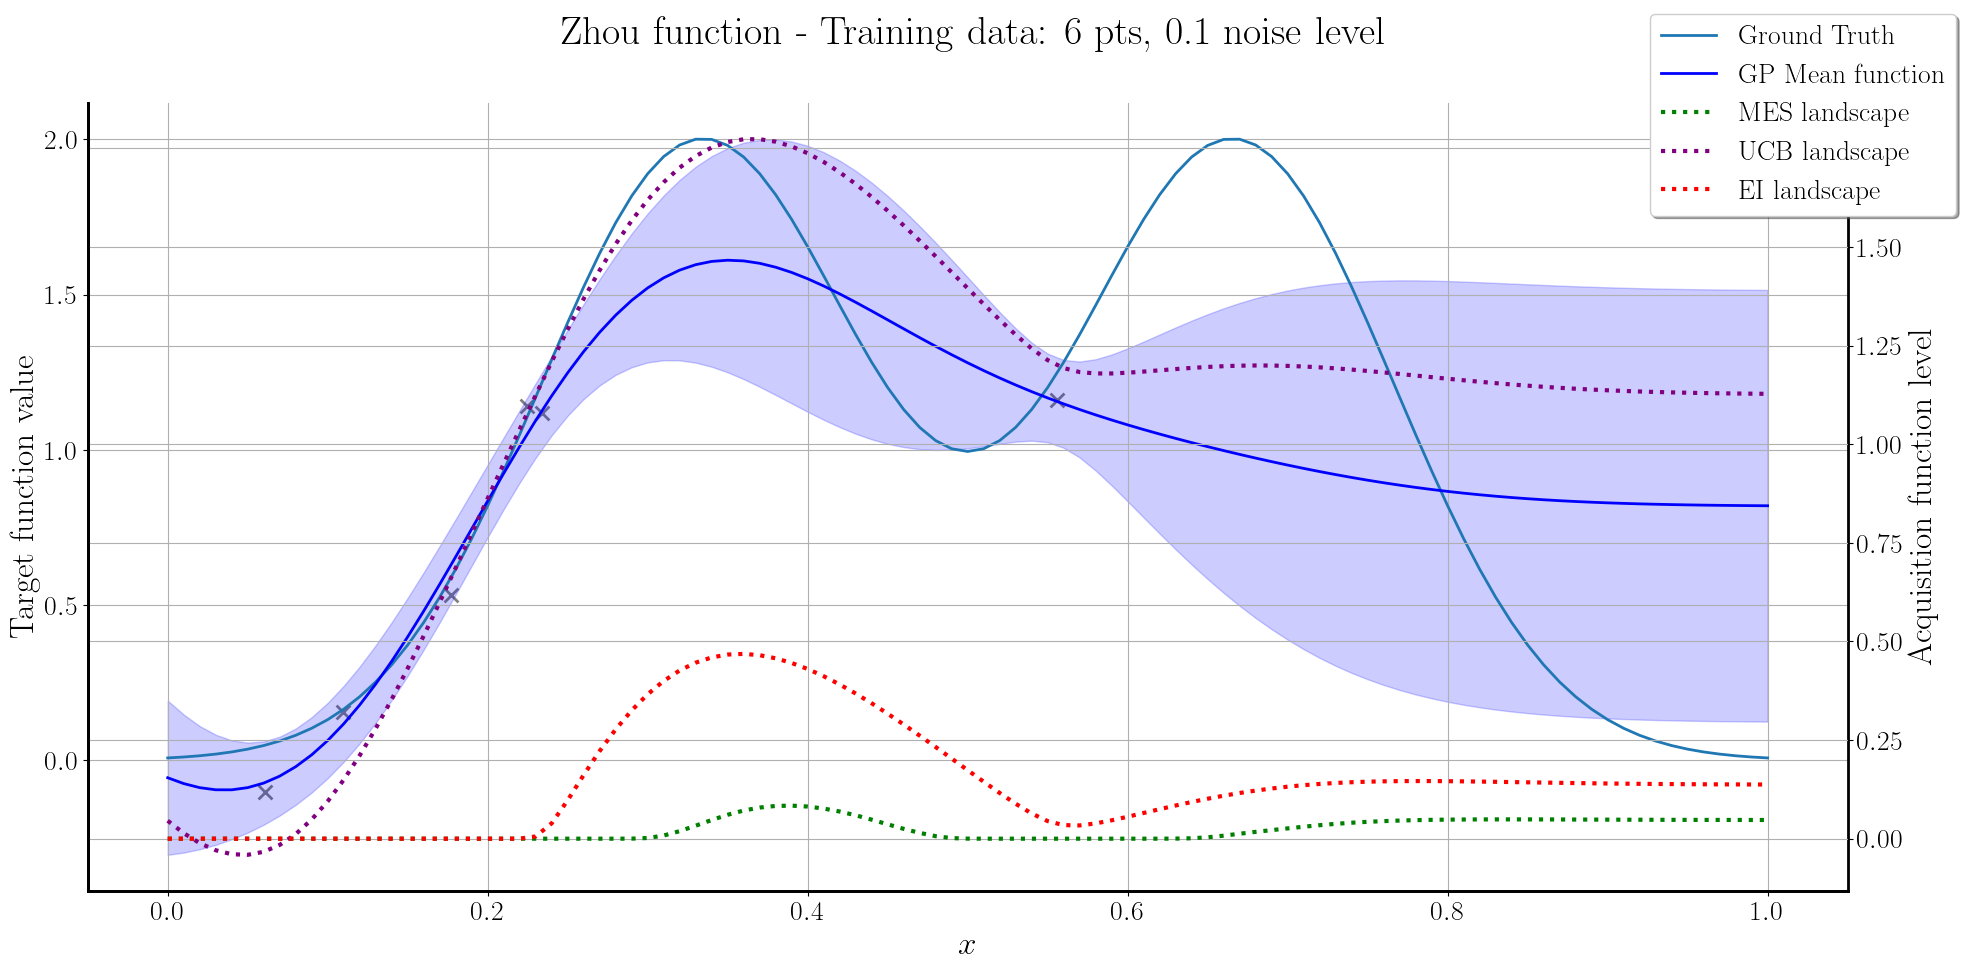

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
axes.plot(X, Y, label='Ground Truth')
axes.scatter(data["train_X"], data["train_Y"], alpha=.5, color='black', marker='x', s=100)
axes.plot(X, gpr_post_mean, 'b', label='GP Mean function')
axes.fill_between(X.squeeze(), gpr_post_mean - gpr_post_var,
                     gpr_post_mean + gpr_post_var, alpha=0.2, color='b')
ax2 = axes.twinx()
ax2.plot(X, mes_eval, linestyle='dotted', color='green', linewidth=3, label='MES landscape')
ax2.plot(X, ucb_eval, linestyle='dotted', color='purple', linewidth=3, label='UCB landscape')
ax2.plot(X, ei_eval, linestyle='dotted', color='red', linewidth=3, label='EI landscape')

ax2.set_ylabel("Acquisition function level")
axes.set_ylabel('Target function value')
axes.set_xlabel('$x$')
axes.spines['right'].set_visible(True)
fig.suptitle(f"Zhou function - Training data: {n_init} pts, {sigma} noise level")
fig.legend(shadow=True)
fig.tight_layout()
plt.show()

In [9]:
##### BO LOOP
data["regrets"] = torch.zeros(budget + 1)
data["regrets"][0] = problem.optimal_value - data["train_Y"].max()
for b in range(budget):
    af = pick_acqf(acqf, data, gpr, bounds)
    candidates, _ = optimize_acqf(
                            acq_function=af, 
                            bounds=bounds,
                            q=1, # batch size, i.e. we only query one point
                            num_restarts=10,
                            raw_samples=512,
                            )
    y = problem(candidates)
    data["train_X"] = torch.cat((data["train_X"], candidates))
    data["train_Y"] = torch.cat((data["train_Y"], y.view(-1, 1)))
    data["regrets"][b + 1] = problem.optimal_value - data["train_Y"].max()                           
    gpr = SingleTaskGP(data["train_X"], data["train_Y"], covar_module=pick_kernel(ker, dim))
    mll = ExactMarginalLogLikelihood(gpr.likelihood, gpr)
    fit_gpytorch_model(mll, max_retries=10);

gpr_post_mean = gpr.likelihood(gpr(X)).mean.detach().numpy()
gpr_post_var = np.sqrt(gpr.likelihood(gpr(X)).variance.detach().numpy())

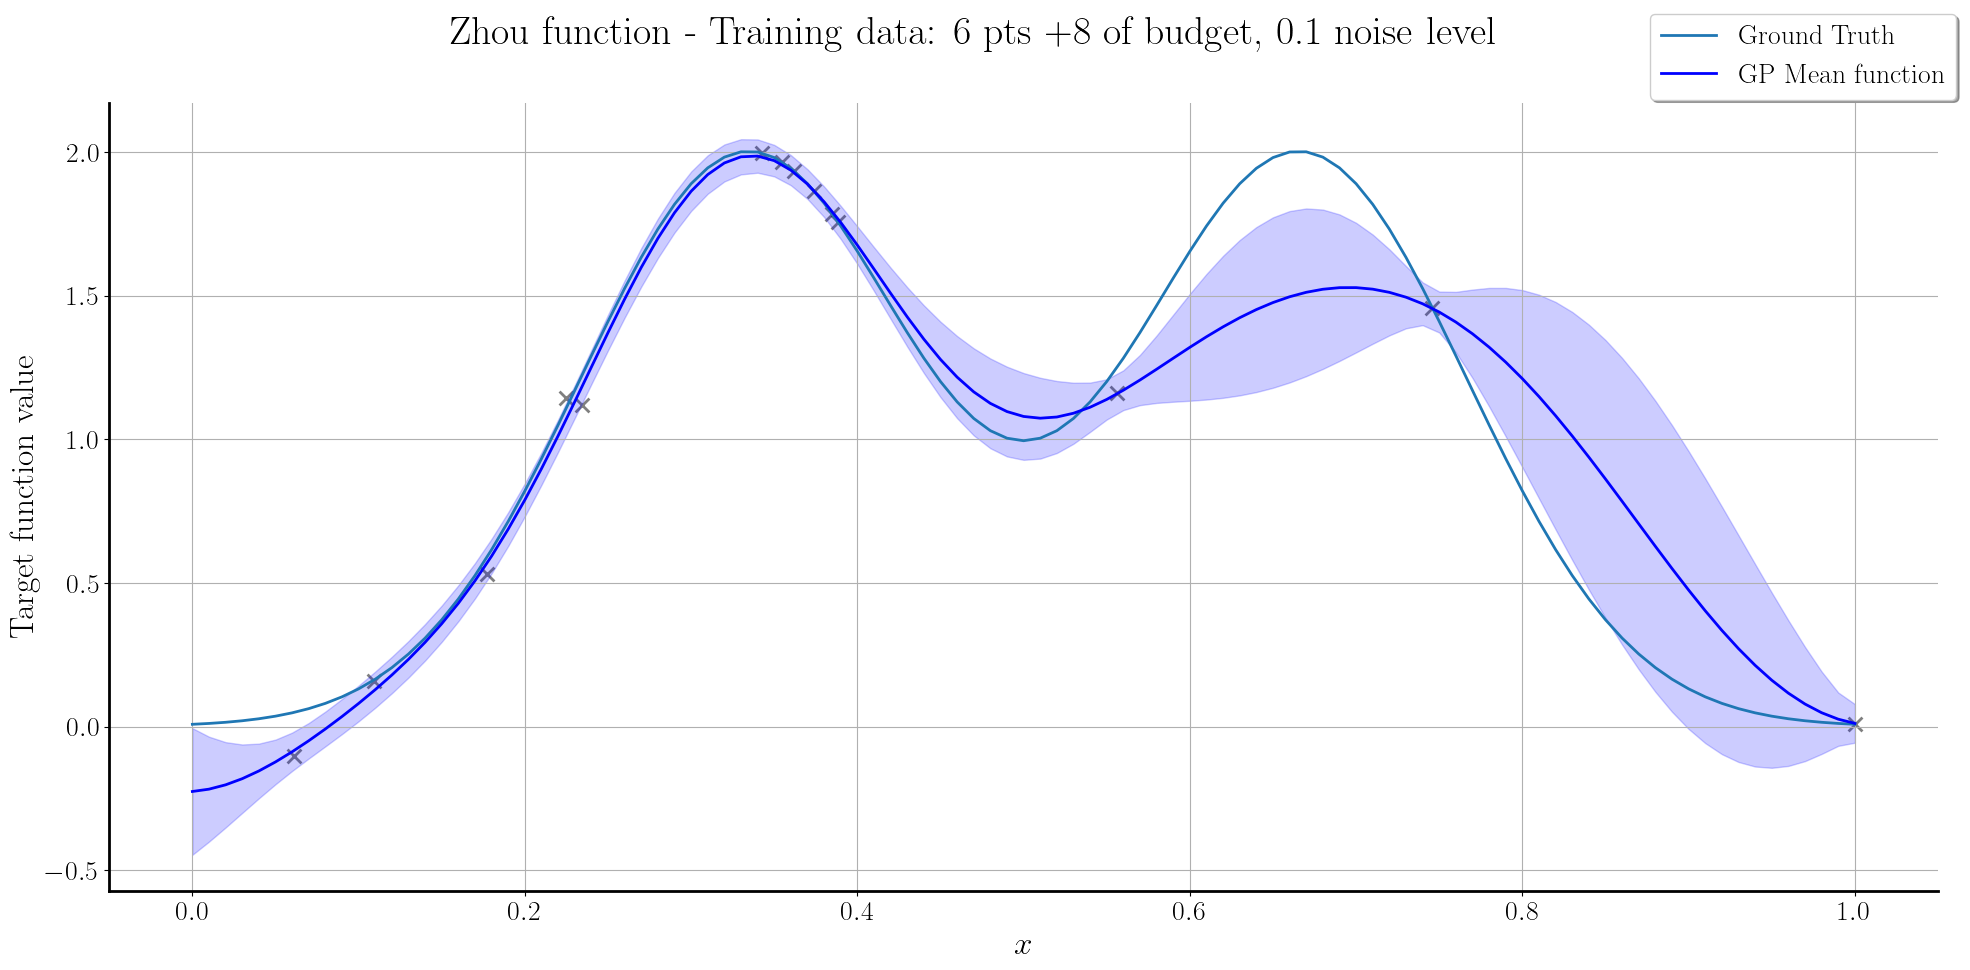

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
axes.plot(X, Y, label='Ground Truth')
axes.scatter(data["train_X"], data["train_Y"], alpha=.5, color='black', marker='x', s=100)
axes.plot(X, gpr_post_mean, 'b', label='GP Mean function')
axes.fill_between(X.squeeze(), gpr_post_mean - gpr_post_var,
                     gpr_post_mean + gpr_post_var, alpha=0.2, color='b')
axes.set_ylabel('Target function value')
axes.set_xlabel('$x$')
fig.suptitle(f"Zhou function - Training data: {n_init} pts +{budget} of budget, {sigma} noise level")
fig.legend(shadow=True)
fig.tight_layout()
plt.show()